In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split #sklearn.cross_validation for lower python versions
from collections import defaultdict, Counter
from pprint import pprint
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
#from sklearn.externals import joblib
import joblib

And tune pandas display options:

In [3]:
pd.set_option('display.width', 3000)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [5]:
os.getcwd()

'C:\\Users\\JHAS23\\Documents\\TTRCM\\ATTRCM Model Training & CA Validation'

In [6]:
# For Local use set Current Working directory path
# os.chdir('<path>')

# Current working directory must have all the input files required

In [7]:
path = os.getcwd().strip() + '/training_input (IQVIA derivation dataset).csv' #Input for training

## 2. Importing Model Input File

**Reading dataset from defined path:**

In [8]:
model_input = pd.read_csv(path)
print ('Base data has %i rows and %i columns' % (model_input.shape[0], model_input.shape[1]))
print ('Displaying first 5 rows')
model_input.head(5)

Base data has 2142 rows and 1877 columns
Displaying first 5 rows


,patient_id,cohort_type,abdominal_and_pelvic_pain,abdominal_aortic_aneurysm__without_rupture,abdominal_distension__gaseous_,abn_findings_on_dx_imaging_of_abd_regions__inc_retroperiton,abnormal_and_inconclusive_findings_on_dx_imaging_of_breast,abnormal_blood_pressure_reading__without_diagnosis,abnormal_coagulation_profile,abnormal_electrocardiogram__ecg___ekg_,abnormal_finding_of_blood_chemistry__unspecified,abnormal_findings_on_diagnostic_imaging_and_in_function_studies__without_diagnosis,abnormal_findings_on_diagnostic_imaging_of_body_structures,abnormal_findings_on_diagnostic_imaging_of_cnsl,abnormal_findings_on_diagnostic_imaging_of_limbs,abnormal_findings_on_diagnostic_imaging_of_lung,abnormal_findings_on_diagnostic_imaging_of_prt_ms_sys,abnormal_findings_on_dx_imaging_of_heart_and_cor_circ,abnormal_findings_on_dx_imaging_of_liver_and_biliary_tract,abnormal_findings_on_dx_imaging_of_prt_digestive_tract,abnormal_findings_on_dx_imaging_of_skull_and_head__nec,abnormal_findings_on_examination_of_blood__without_diagnosis,abnormal_findings_on_examination_of_other_body_fluids__substances_and_tissues__without_diagnosis,abnormal_findings_on_examination_of_urine__without_diagnosis,abnormal_involuntary_movements,abnormal_level_of_blood_mineral,abnormal_levels_of_other_serum_enzymes,abnormal_posture,abnormal_result_of_cardiovascular_function_study__unsp,abnormal_result_of_other_cardiovascular_function_study,abnormal_results_of_function_studies,abnormal_results_of_kidney_function_studies,abnormal_results_of_liver_function_studies,abnormal_results_of_pulmonary_function_studies,abnormal_results_of_thyroid_function_studies,abnormal_serum_enzyme_levels,abnormal_tumor_markers,abnormal_weight_gain,abnormal_weight_loss,abnormalities_of_breathing,abnormalities_of_gait_and_mobility,abnormalities_of_heart_beat,abscess__furuncle_and_carbuncle_of_nose,accidental_exposure_to_other_specified_factors,accidental_falls,accidental_poisoning_by_alcohol__not_elsewhere_classified,accidental_poisoning_by_other_solid_and_liquid_substances__gases__and_vapors,acidosis,acne,acquired_absence_of_organs__not_elsewhere_classified,acquired_absence_of_other_genital_organ_s_,acquired_absence_of_other_specified_parts_of_digestive_tract,acquired_deformities_of_fingers_and_toes,acquired_ichthyosis,acquired_keratosis__keratoderma__palmaris_et_plantaris,acquired_keratosis_follicularis,actinic_keratosis,activity,acute_and_chronic_respiratory_failure_with_hypoxia,acute_bronchitis,acute_bronchitis__unspecified,acute_bronchospasm,acute_cerebrovascular_insufficiency,acute_combined_systolic_and_diastolic__congestive__hrt_fail,acute_cystitis_with_hematuria,acute_cystitis_without_hematuria,acute_diastolic__congestive__heart_failure,acute_embolism_and_thombos_unsp_deep_vn_unsp_lower_extremity,acute_gastritis_without_bleeding,acute_kidney_failure,acute_kidney_failure__unspecified,acute_kidney_failure_and_chronic_kidney_disease,acute_kidney_failure_with_tubular_necrosis,acute_lymphangitis__unspecified,acute_lymphangitis_of_unspecified_part_of_limb,acute_maxillary_sinusitis__unspecified,acute_nasopharyngitis__common_cold_,acute_on_chronic_combined_systolic_and_diastolic_hrt_fail,acute_on_chronic_diastolic__congestive__heart_failure,acute_on_chronic_systolic__congestive__heart_failure,acute_pharyngitis,acute_pharyngitis__unspecified,acute_posthemorrhagic_anemia,acute_pulmonary_edema,acute_respiratory_failure__unsp_w_hypoxia_or_hypercapnia,acute_respiratory_failure_with_hypoxia,acute_sinusitis,acute_sinusitis__unspecified,acute_systolic__congestive__heart_failure,acute_upper_resp_infections_of_multiple_and_unsp_sites,acute_upper_respiratory_infection__unspecified,acute_upper_respiratory_infections,adjustment_disorder__unspecified,adjustment_disorder_with_depressed_mood,adjustment_disorder_with_mixed_anxiety_and_depressed_mood,adult_failure_to_thrive,adverse_effect_of_unsp_drug_meds_biol_subst__init,adverse_effects__not_elsewhere_classified,aftercare_following_joint_replacement_surgery,a

**Checking if there are any empty cells in model_input**

In [8]:
if model_input.isnull().values.any() == 'True':
    raise ValueError('Model Input File has null values')
else:
    print ('There are no empty values in the dataset')

There are no empty values in the dataset


**Level of data is patient_id. Each row uniquely identifies a patient**

In [9]:
row_count = model_input.shape[0]
patient_count = len(model_input['patient_id'].unique())
if row_count == patient_count:
    print ('Row Count: ', model_input.shape[0])
    print ('Patient Count: ', len(model_input['patient_id'].unique()))
else:
    raise ValueError('Model Input File is not at required level of data (patient_id)')

Row Count:  2142
Patient Count:  2142


**ATTR WT patients are matched 1:1 with HF using Propensity Score Matching giving us 817 patients for each cohort ATTR WT and HF**

In [10]:
model_input.groupby(['cohort_type','cohort_flag']).patient_id.nunique()

cohort_type    cohort_flag
Control Group  0              1071
Wild Type      1              1071
Name: patient_id, dtype: int64

cohort_flag is 1 for ATTR WT patients. We would drop cohort_type and use cohort_flag as target for training

## 3. Pre-processing

**Dropping columns not required for training the model**

In [11]:
model_input = model_input.drop(['patient_id','cohort_type'], axis = 1)
model_input.head(5)

,abdominal_and_pelvic_pain,abdominal_aortic_aneurysm__without_rupture,abdominal_distension__gaseous_,abn_findings_on_dx_imaging_of_abd_regions__inc_retroperiton,abnormal_and_inconclusive_findings_on_dx_imaging_of_breast,abnormal_blood_pressure_reading__without_diagnosis,abnormal_coagulation_profile,abnormal_electrocardiogram__ecg___ekg_,abnormal_finding_of_blood_chemistry__unspecified,abnormal_findings_on_diagnostic_imaging_and_in_function_studies__without_diagnosis,abnormal_findings_on_diagnostic_imaging_of_body_structures,abnormal_findings_on_diagnostic_imaging_of_cnsl,abnormal_findings_on_diagnostic_imaging_of_limbs,abnormal_findings_on_diagnostic_imaging_of_lung,abnormal_findings_on_diagnostic_imaging_of_prt_ms_sys,abnormal_findings_on_dx_imaging_of_heart_and_cor_circ,abnormal_findings_on_dx_imaging_of_liver_and_biliary_tract,abnormal_findings_on_dx_imaging_of_prt_digestive_tract,abnormal_findings_on_dx_imaging_of_skull_and_head__nec,abnormal_findings_on_examination_of_blood__without_diagnosis,abnormal_findings_on_examination_of_other_body_fluids__substances_and_tissues__without_diagnosis,abnormal_findings_on_examination_of_urine__without_diagnosis,abnormal_involuntary_movements,abnormal_level_of_blood_mineral,abnormal_levels_of_other_serum_enzymes,abnormal_posture,abnormal_result_of_cardiovascular_function_study__unsp,abnormal_result_of_other_cardiovascular_function_study,abnormal_results_of_function_studies,abnormal_results_of_kidney_function_studies,abnormal_results_of_liver_function_studies,abnormal_results_of_pulmonary_function_studies,abnormal_results_of_thyroid_function_studies,abnormal_serum_enzyme_levels,abnormal_tumor_markers,abnormal_weight_gain,abnormal_weight_loss,abnormalities_of_breathing,abnormalities_of_gait_and_mobility,abnormalities_of_heart_beat,abscess__furuncle_and_carbuncle_of_nose,accidental_exposure_to_other_specified_factors,accidental_falls,accidental_poisoning_by_alcohol__not_elsewhere_classified,accidental_poisoning_by_other_solid_and_liquid_substances__gases__and_vapors,acidosis,acne,acquired_absence_of_organs__not_elsewhere_classified,acquired_absence_of_other_genital_organ_s_,acquired_absence_of_other_specified_parts_of_digestive_tract,acquired_deformities_of_fingers_and_toes,acquired_ichthyosis,acquired_keratosis__keratoderma__palmaris_et_plantaris,acquired_keratosis_follicularis,actinic_keratosis,activity,acute_and_chronic_respiratory_failure_with_hypoxia,acute_bronchitis,acute_bronchitis__unspecified,acute_bronchospasm,acute_cerebrovascular_insufficiency,acute_combined_systolic_and_diastolic__congestive__hrt_fail,acute_cystitis_with_hematuria,acute_cystitis_without_hematuria,acute_diastolic__congestive__heart_failure,acute_embolism_and_thombos_unsp_deep_vn_unsp_lower_extremity,acute_gastritis_without_bleeding,acute_kidney_failure,acute_kidney_failure__unspecified,acute_kidney_failure_and_chronic_kidney_disease,acute_kidney_failure_with_tubular_necrosis,acute_lymphangitis__unspecified,acute_lymphangitis_of_unspecified_part_of_limb,acute_maxillary_sinusitis__unspecified,acute_nasopharyngitis__common_cold_,acute_on_chronic_combined_systolic_and_diastolic_hrt_fail,acute_on_chronic_diastolic__congestive__heart_failure,acute_on_chronic_systolic__congestive__heart_failure,acute_pharyngitis,acute_pharyngitis__unspecified,acute_posthemorrhagic_anemia,acute_pulmonary_edema,acute_respiratory_failure__unsp_w_hypoxia_or_hypercapnia,acute_respiratory_failure_with_hypoxia,acute_sinusitis,acute_sinusitis__unspecified,acute_systolic__congestive__heart_failure,acute_upper_resp_infections_of_multiple_and_unsp_sites,acute_upper_respiratory_infection__unspecified,acute_upper_respiratory_infections,adjustment_disorder__unspecified,adjustment_disorder_with_depressed_mood,adjustment_disorder_with_mixed_anxiety_and_depressed_mood,adult_failure_to_thrive,adverse_effect_of_unsp_drug_meds_biol_subst__init,adverse_effects__not_elsewhere_classified,aftercare_following_joint_replacement_surgery,age_related_cataract,age

**We are now going to handle the target variable (cohort_flag) and store it in a new variable:**

In [12]:
target_map = {u'1': 1, u'0': 0}
model_input['__target__'] = model_input['cohort_flag'].map(str).map(target_map)
model_input = model_input.drop(['cohort_flag'], axis = 1)

model_input.groupby(['__target__']).count()

,abdominal_and_pelvic_pain,abdominal_aortic_aneurysm__without_rupture,abdominal_distension__gaseous_,abn_findings_on_dx_imaging_of_abd_regions__inc_retroperiton,abnormal_and_inconclusive_findings_on_dx_imaging_of_breast,abnormal_blood_pressure_reading__without_diagnosis,abnormal_coagulation_profile,abnormal_electrocardiogram__ecg___ekg_,abnormal_finding_of_blood_chemistry__unspecified,abnormal_findings_on_diagnostic_imaging_and_in_function_studies__without_diagnosis,abnormal_findings_on_diagnostic_imaging_of_body_structures,abnormal_findings_on_diagnostic_imaging_of_cnsl,abnormal_findings_on_diagnostic_imaging_of_limbs,abnormal_findings_on_diagnostic_imaging_of_lung,abnormal_findings_on_diagnostic_imaging_of_prt_ms_sys,abnormal_findings_on_dx_imaging_of_heart_and_cor_circ,abnormal_findings_on_dx_imaging_of_liver_and_biliary_tract,abnormal_findings_on_dx_imaging_of_prt_digestive_tract,abnormal_findings_on_dx_imaging_of_skull_and_head__nec,abnormal_findings_on_examination_of_blood__without_diagnosis,abnormal_findings_on_examination_of_other_body_fluids__substances_and_tissues__without_diagnosis,abnormal_findings_on_examination_of_urine__without_diagnosis,abnormal_involuntary_movements,abnormal_level_of_blood_mineral,abnormal_levels_of_other_serum_enzymes,abnormal_posture,abnormal_result_of_cardiovascular_function_study__unsp,abnormal_result_of_other_cardiovascular_function_study,abnormal_results_of_function_studies,abnormal_results_of_kidney_function_studies,abnormal_results_of_liver_function_studies,abnormal_results_of_pulmonary_function_studies,abnormal_results_of_thyroid_function_studies,abnormal_serum_enzyme_levels,abnormal_tumor_markers,abnormal_weight_gain,abnormal_weight_loss,abnormalities_of_breathing,abnormalities_of_gait_and_mobility,abnormalities_of_heart_beat,abscess__furuncle_and_carbuncle_of_nose,accidental_exposure_to_other_specified_factors,accidental_falls,accidental_poisoning_by_alcohol__not_elsewhere_classified,accidental_poisoning_by_other_solid_and_liquid_substances__gases__and_vapors,acidosis,acne,acquired_absence_of_organs__not_elsewhere_classified,acquired_absence_of_other_genital_organ_s_,acquired_absence_of_other_specified_parts_of_digestive_tract,acquired_deformities_of_fingers_and_toes,acquired_ichthyosis,acquired_keratosis__keratoderma__palmaris_et_plantaris,acquired_keratosis_follicularis,actinic_keratosis,activity,acute_and_chronic_respiratory_failure_with_hypoxia,acute_bronchitis,acute_bronchitis__unspecified,acute_bronchospasm,acute_cerebrovascular_insufficiency,acute_combined_systolic_and_diastolic__congestive__hrt_fail,acute_cystitis_with_hematuria,acute_cystitis_without_hematuria,acute_diastolic__congestive__heart_failure,acute_embolism_and_thombos_unsp_deep_vn_unsp_lower_extremity,acute_gastritis_without_bleeding,acute_kidney_failure,acute_kidney_failure__unspecified,acute_kidney_failure_and_chronic_kidney_disease,acute_kidney_failure_with_tubular_necrosis,acute_lymphangitis__unspecified,acute_lymphangitis_of_unspecified_part_of_limb,acute_maxillary_sinusitis__unspecified,acute_nasopharyngitis__common_cold_,acute_on_chronic_combined_systolic_and_diastolic_hrt_fail,acute_on_chronic_diastolic__congestive__heart_failure,acute_on_chronic_systolic__congestive__heart_failure,acute_pharyngitis,acute_pharyngitis__unspecified,acute_posthemorrhagic_anemia,acute_pulmonary_edema,acute_respiratory_failure__unsp_w_hypoxia_or_hypercapnia,acute_respiratory_failure_with_hypoxia,acute_sinusitis,acute_sinusitis__unspecified,acute_systolic__congestive__heart_failure,acute_upper_resp_infections_of_multiple_and_unsp_sites,acute_upper_respiratory_infection__unspecified,acute_upper_respiratory_infections,adjustment_disorder__unspecified,adjustment_disorder_with_depressed_mood,adjustment_disorder_with_mixed_anxiety_and_depressed_mood,adult_failure_to_thrive,adverse_effect_of_unsp_drug_meds_biol_subst__init,adverse_effects__not_elsewhere_classified,aftercare_following_joint_replacement_surgery,age_related_cataract,age

In [13]:
potential_target_leaks = []

model_input_flt_leaks = model_input.drop(potential_target_leaks, axis = 1)
model_input_flt_leaks.head(5)

,abdominal_and_pelvic_pain,abdominal_aortic_aneurysm__without_rupture,abdominal_distension__gaseous_,abn_findings_on_dx_imaging_of_abd_regions__inc_retroperiton,abnormal_and_inconclusive_findings_on_dx_imaging_of_breast,abnormal_blood_pressure_reading__without_diagnosis,abnormal_coagulation_profile,abnormal_electrocardiogram__ecg___ekg_,abnormal_finding_of_blood_chemistry__unspecified,abnormal_findings_on_diagnostic_imaging_and_in_function_studies__without_diagnosis,abnormal_findings_on_diagnostic_imaging_of_body_structures,abnormal_findings_on_diagnostic_imaging_of_cnsl,abnormal_findings_on_diagnostic_imaging_of_limbs,abnormal_findings_on_diagnostic_imaging_of_lung,abnormal_findings_on_diagnostic_imaging_of_prt_ms_sys,abnormal_findings_on_dx_imaging_of_heart_and_cor_circ,abnormal_findings_on_dx_imaging_of_liver_and_biliary_tract,abnormal_findings_on_dx_imaging_of_prt_digestive_tract,abnormal_findings_on_dx_imaging_of_skull_and_head__nec,abnormal_findings_on_examination_of_blood__without_diagnosis,abnormal_findings_on_examination_of_other_body_fluids__substances_and_tissues__without_diagnosis,abnormal_findings_on_examination_of_urine__without_diagnosis,abnormal_involuntary_movements,abnormal_level_of_blood_mineral,abnormal_levels_of_other_serum_enzymes,abnormal_posture,abnormal_result_of_cardiovascular_function_study__unsp,abnormal_result_of_other_cardiovascular_function_study,abnormal_results_of_function_studies,abnormal_results_of_kidney_function_studies,abnormal_results_of_liver_function_studies,abnormal_results_of_pulmonary_function_studies,abnormal_results_of_thyroid_function_studies,abnormal_serum_enzyme_levels,abnormal_tumor_markers,abnormal_weight_gain,abnormal_weight_loss,abnormalities_of_breathing,abnormalities_of_gait_and_mobility,abnormalities_of_heart_beat,abscess__furuncle_and_carbuncle_of_nose,accidental_exposure_to_other_specified_factors,accidental_falls,accidental_poisoning_by_alcohol__not_elsewhere_classified,accidental_poisoning_by_other_solid_and_liquid_substances__gases__and_vapors,acidosis,acne,acquired_absence_of_organs__not_elsewhere_classified,acquired_absence_of_other_genital_organ_s_,acquired_absence_of_other_specified_parts_of_digestive_tract,acquired_deformities_of_fingers_and_toes,acquired_ichthyosis,acquired_keratosis__keratoderma__palmaris_et_plantaris,acquired_keratosis_follicularis,actinic_keratosis,activity,acute_and_chronic_respiratory_failure_with_hypoxia,acute_bronchitis,acute_bronchitis__unspecified,acute_bronchospasm,acute_cerebrovascular_insufficiency,acute_combined_systolic_and_diastolic__congestive__hrt_fail,acute_cystitis_with_hematuria,acute_cystitis_without_hematuria,acute_diastolic__congestive__heart_failure,acute_embolism_and_thombos_unsp_deep_vn_unsp_lower_extremity,acute_gastritis_without_bleeding,acute_kidney_failure,acute_kidney_failure__unspecified,acute_kidney_failure_and_chronic_kidney_disease,acute_kidney_failure_with_tubular_necrosis,acute_lymphangitis__unspecified,acute_lymphangitis_of_unspecified_part_of_limb,acute_maxillary_sinusitis__unspecified,acute_nasopharyngitis__common_cold_,acute_on_chronic_combined_systolic_and_diastolic_hrt_fail,acute_on_chronic_diastolic__congestive__heart_failure,acute_on_chronic_systolic__congestive__heart_failure,acute_pharyngitis,acute_pharyngitis__unspecified,acute_posthemorrhagic_anemia,acute_pulmonary_edema,acute_respiratory_failure__unsp_w_hypoxia_or_hypercapnia,acute_respiratory_failure_with_hypoxia,acute_sinusitis,acute_sinusitis__unspecified,acute_systolic__congestive__heart_failure,acute_upper_resp_infections_of_multiple_and_unsp_sites,acute_upper_respiratory_infection__unspecified,acute_upper_respiratory_infections,adjustment_disorder__unspecified,adjustment_disorder_with_depressed_mood,adjustment_disorder_with_mixed_anxiety_and_depressed_mood,adult_failure_to_thrive,adverse_effect_of_unsp_drug_meds_biol_subst__init,adverse_effects__not_elsewhere_classified,aftercare_following_joint_replacement_surgery,age_related_cataract,age

**Splitting model_input into test and train**

The dataset needs to be split into 2 new sets, one that will be used for training the model (train set)
and another that will be used to test its generalization capability (test set)

In [14]:
X = model_input_flt_leaks.drop('__target__', axis=1)
y = np.array(model_input_flt_leaks['__target__'])

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print ('Train data has %i rows and %i columns' % (train_X.shape[0], train_X.shape[1]))
print ('Test data has %i rows and %i columns' % (test_X.shape[0], test_X.shape[1]))

Train data has 1713 rows and 1874 columns
Test data has 429 rows and 1874 columns


In [15]:
#pd.DataFrame(train_X).to_csv('train_X.csv')

**Displaying all features**

In [16]:
features = list(train_X)
print (len(features), ' features')
display(features)

1874  features


['abdominal_and_pelvic_pain',
 'abdominal_aortic_aneurysm__without_rupture',
 'abdominal_distension__gaseous_',
 'abn_findings_on_dx_imaging_of_abd_regions__inc_retroperiton',
 'abnormal_and_inconclusive_findings_on_dx_imaging_of_breast',
 'abnormal_blood_pressure_reading__without_diagnosis',
 'abnormal_coagulation_profile',
 'abnormal_electrocardiogram__ecg___ekg_',
 'abnormal_finding_of_blood_chemistry__unspecified',
 'abnormal_findings_on_diagnostic_imaging_and_in_function_studies__without_diagnosis',
 'abnormal_findings_on_diagnostic_imaging_of_body_structures',
 'abnormal_findings_on_diagnostic_imaging_of_cnsl',
 'abnormal_findings_on_diagnostic_imaging_of_limbs',
 'abnormal_findings_on_diagnostic_imaging_of_lung',
 'abnormal_findings_on_diagnostic_imaging_of_prt_ms_sys',
 'abnormal_findings_on_dx_imaging_of_heart_and_cor_circ',
 'abnormal_findings_on_dx_imaging_of_liver_and_biliary_tract',
 'abnormal_findings_on_dx_imaging_of_prt_digestive_tract',
 'abnormal_findings_on_dx_imagin

## 4. Creating model object

In [17]:
 from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 4)]

# Number of features to consider at every split
max_features = ['auto']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 4)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2,3,5,7]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3,4,5]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
total_combinations = len(n_estimators)*len(max_features)*len(max_depth)*len(min_samples_split)*len(min_samples_leaf)*len(bootstrap)
print('Trying out total combinations: ', total_combinations)
print(param_grid)

Trying out total combinations:  640
{'n_estimators': [200, 300, 400, 500], 'max_features': ['auto'], 'max_depth': [5, 10, 15, 20, None], 'min_samples_split': [2, 3, 5, 7], 'min_samples_leaf': [2, 3, 4, 5], 'bootstrap': [True, False]}


In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=10000)

# Random search of parameters, using 3 fold cross validation, 
# search across different combinations
%time rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)

# Fit the random search model
%time rf_grid.fit(train_X, train_y)

Wall time: 0 ns
Fitting 3 folds for each of 640 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 40.9min finished


Wall time: 41min 1s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10000),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20, None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [200, 300, 400, 500]},
             verbose=2)

In [19]:
rf_grid.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 400}

In [20]:
bestparams_clf=rf_grid.best_params_
bestparams_clf

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 400}

In [21]:
clf = RandomForestClassifier(n_estimators=bestparams_clf['n_estimators'],random_state= 10000, min_samples_leaf= bestparams_clf['min_samples_leaf'])
clf

RandomForestClassifier(min_samples_leaf=2, n_estimators=400, random_state=10000)

In [22]:
%time clf.fit(train_X, train_y)

Wall time: 8.11 s


RandomForestClassifier(min_samples_leaf=2, n_estimators=400, random_state=10000)

In [23]:
best_grid = rf_grid.best_estimator_
_clf_base_predictions = best_grid.predict(test_X)
_clf_base_probas = best_grid.predict_proba(test_X)

test_y_series = pd.Series(data=test_y, index=test_X.index, name='cohort_flag')
test_y_labels = test_y_series.to_frame()

clf_base_predictions = pd.Series(data=_clf_base_predictions, index=test_X.index, name='predicted_value')
cols = [
    u'probability_of_value_%s' % label
    for (_, label) in sorted([(int(target_map[label]), label) for label in target_map])
]

clf_base_probabilities = pd.DataFrame(data=_clf_base_probas, index=test_X.index, columns=cols)

clf_base_results_test = test_y_labels.join(clf_base_predictions, how='left')
clf_base_results_test = clf_base_results_test.join(clf_base_probabilities, how='left')

In [24]:
# Model performance metrics

print ('Accuracy:'),print(metrics.accuracy_score(test_y, _clf_base_predictions))
print ('\nF1 Score:'),print(metrics.f1_score(test_y, _clf_base_predictions))
print ('\nRecall:'),print(metrics.recall_score(test_y, _clf_base_predictions))
print ('\nPrecision:'),print(metrics.precision_score(test_y, _clf_base_predictions))
print ('\nClassification report:'),print(metrics.classification_report(test_y, _clf_base_predictions))
print ('\nConfusion matrix:'),print(metrics.confusion_matrix(test_y, _clf_base_predictions))

Accuracy:
0.8787878787878788

F1 Score:
0.8761904761904762

Recall:
0.8558139534883721

Precision:
0.8975609756097561

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       214
           1       0.90      0.86      0.88       215

    accuracy                           0.88       429
   macro avg       0.88      0.88      0.88       429
weighted avg       0.88      0.88      0.88       429


Confusion matrix:
[[193  21]
 [ 31 184]]


(None, None)

In [25]:
clf_base_results_test

,cohort_flag,predicted_value,probability_of_value_0,probability_of_value_1
350,0,0,0.640154,0.359846
2055,1,1,0.218710,0.781290
686,0,0,0.766215,0.233785
602,0,0,0.689525,0.310475
571,1,1,0.262983,0.737017
...,...,...,...,...
1292,1,1,0.139223,0.860777
535,1,1,0.301784,0.698216
163,1,1,0.243416,0.756584
203,1,1,0.251447,0.748553


In [26]:
print ('Area under curve:', metrics.roc_auc_score(clf_base_results_test['cohort_flag'],clf_base_results_test['probability_of_value_1']))

Area under curve: 0.9374701151923495


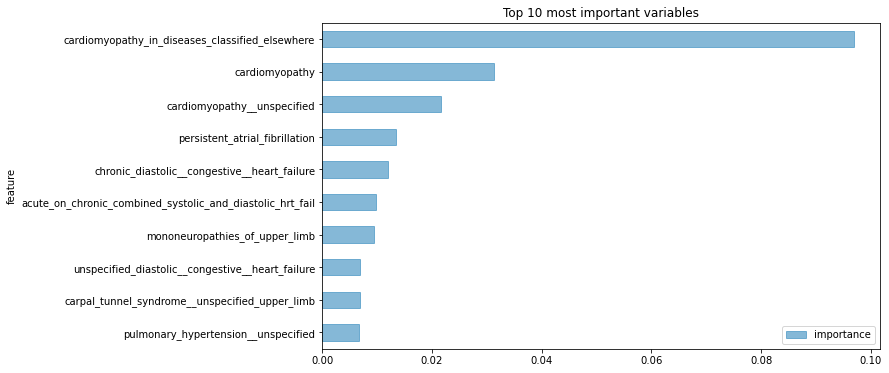

In [27]:
feature_importances_data = []
features = train_X.columns
for feature_name, feature_importance in zip(features, clf.feature_importances_):
    feature_importances_data.append({
        'feature': feature_name,
        'importance': feature_importance
    })

# Plot the results
pd.DataFrame(feature_importances_data)\
    .set_index('feature')\
    .sort_values(by='importance')[-10::]\
    .plot(title='Top 10 most important variables',
          kind='barh',
          figsize=(10, 6),
          color='#348ABD',
          alpha=0.6,
          lw='1',
          edgecolor='#348ABD',
          grid=False,)

In [28]:
# Saving the feature importance

pd.DataFrame(feature_importances_data).to_csv('feature_importance_all.csv')

In [29]:
#handle = dataiku.Folder("0h3MrWHS")
path = os.getcwd()

filename = path+'/rf_best_incl_all_features_3_6.sav'
joblib.dump(clf, filename)

['C:\\Users\\JHAS23\\Documents\\TTRCM\\ATTRCM Model Training & CA Validation/rf_best_incl_all_features_3_6.sav']